Data from 
Cai, Jing, Alain De Janvry, and Elisabeth Sadoulet. 2015. "Social Networks and the Decision to Insure." American Economic Journal: Applied Economics, 7(2): 81-108. https://www.aeaweb.org/articles.php?doi=10.1257/app.20130442

In [51]:
options(warn=-1)
library(foreign)
library(dplyr)
library(igraph)
library(doParallel)
library(ggplot2)
library(broom)
library(tidyr)
library(xtable)
library(lfe)
library(gridExtra)
library(Matrix)
registerDoParallel(cores = 8)
source("simulations/village.R")
source("simulations/estimators.R")
source("simulations/analyze.R")
source("cai_analysis_functions.R")

## Functions

In [2]:
# relies on prep_cai_data.R having been run, likely on a server or cluster
villages = readRDS("cai_villages_with_pi_hat.RDS")
n_villages = length(villages)

In [3]:
cai_all = read.dta('cai-data/data/0422allinforawnet.dta')
cai_survey = read.dta('cai-data/data/0422survey.dta')
cai_price = read.dta('cai-data/data/0422price.dta')
cai_structure = read.dta('cai-data/data/0422structure_all.dta')

In [4]:
cai_survey = cai_survey %>% 
    select(id, address, hh_size=agpop, rice_area=ricearea_2010, takeup_survey, delay, intensive) %>% 
    mutate(id = as.character(id)) %>%
    filter(!is.na(hh_size), !is.na(rice_area))

get_strata = function(cai_df) {
    strata_df = cai_df %>% group_by(address) %>% summarise(
        median_hh_size = median(hh_size),
        median_rice_area = median(rice_area)
    )
    with(
        cai_df %>% left_join(strata_df, by='address'),
        2 * (hh_size <= median_hh_size) + 1 * (rice_area <= median_rice_area)
    )
}
cai_survey$stratum = get_strata(cai_survey)

`summarise()` ungrouping output (override with `.groups` argument)



In [5]:
names(villages[[1]])

[1] "name"               "nodes"              "edges"             
 [4] "graph"              "n_nodes"            "n_edges"           
 [7] "seed_set"           "ss_size"            "y"                 
[10] "p_rand"             "p_nom_unnormalized" "pi_hat"            
[13] "pi_hat_se"          "pi_hat_inv_se"      "p_nom"

In [6]:
villages[[13]]$p_nom_unnormalized
villages[[13]]$p_nom
villages[[13]]$pi_hat^-1
villages[[13]]$pi_hat_inv_se

[1] 3.732855e-10

[1] 2.208787e-09

[1] 5.917151

[1] 0.02402964

In [7]:
villages = foreach(v = villages) %do% {
    idx = match(v$nodes$id, V(v$graph)$name)
    v$nodes = v$nodes %>%
        mutate(
            indegree = degree(v$graph, mode = "in")[idx],
            p_nom = compute_p_nom_one_seed(v$graph)[idx]
        )
    v$y_rate_seeds = mean(v$nodes$takeup_survey[v$nodes$trt])
    v$y_rate_nonseeds = mean(v$nodes$takeup_survey[!v$nodes$trt])
    v$y_rate_delay = mean(v$nodes$takeup_survey[v$nodes$delay == 1])
    v
}

### Exploratory

In [8]:
all_nodes = foreach(v = villages, .combine = rbind) %do% {
    df = v$nodes
    df$village = v$name
    df
    }

In [9]:
all_nodes %>%
    group_by(village) %>%
    summarise(
        n = n(),
        n_intensive = sum(intensive),
        n_delay = sum(delay)
    )

`summarise()` ungrouping output (override with `.groups` argument)



village,n,n_intensive,n_delay
<chr>,<int>,<dbl>,<dbl>
beidangxinzhi,11,5,0
beilian2,28,11,15
beilian4,22,10,12
beixing4,22,13,13
beixing5,19,12,9
beixing712,41,19,22
caijia1,33,16,19
caijia6,43,19,28
chaxishangchaxi,8,4,0


`geom_smooth()` using formula 'y ~ x'



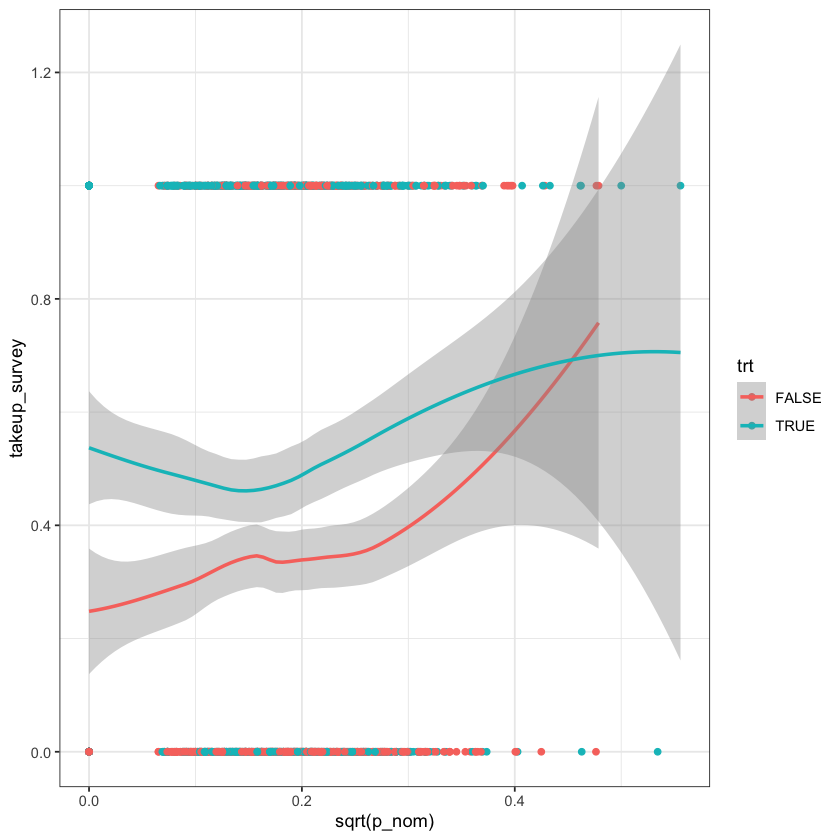

In [10]:
ggplot(
    aes(x = sqrt(p_nom), y = takeup_survey, color = trt),
    data = all_nodes %>% filter(!delay)) +
geom_point() +
geom_smooth(method = "loess") +
theme_bw()

In [11]:
felm_tmp = felm(
    takeup_survey ~ sqrt(p_nom) * trt | village | 0 | village,
    data = all_nodes %>% filter(!delay)
)
summary(felm_tmp, robust = T)


Call:
   felm(formula = takeup_survey ~ sqrt(p_nom) * trt | village |      0 | village, data = all_nodes %>% filter(!delay)) 

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00625 -0.33306 -0.08107  0.37329  0.99864 

Coefficients:
                    Estimate Cluster s.e. t value Pr(>|t|)   
sqrt(p_nom)          0.20597      0.18267   1.128  0.26132   
trtTRUE              0.15253      0.05235   2.914  0.00412 **
sqrt(p_nom):trtTRUE  0.10122      0.25235   0.401  0.68890   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4431 on 1692 degrees of freedom
Multiple R-squared(full model): 0.2618   Adjusted R-squared: 0.1955 
Multiple R-squared(proj model): 0.0387   Adjusted R-squared: -0.04766 
F-statistic(full model, *iid*):3.948 on 152 and 1692 DF, p-value: < 2.2e-16 
F-statistic(proj model): 11.83 on 3 and 149 DF, p-value: 5.398e-07 



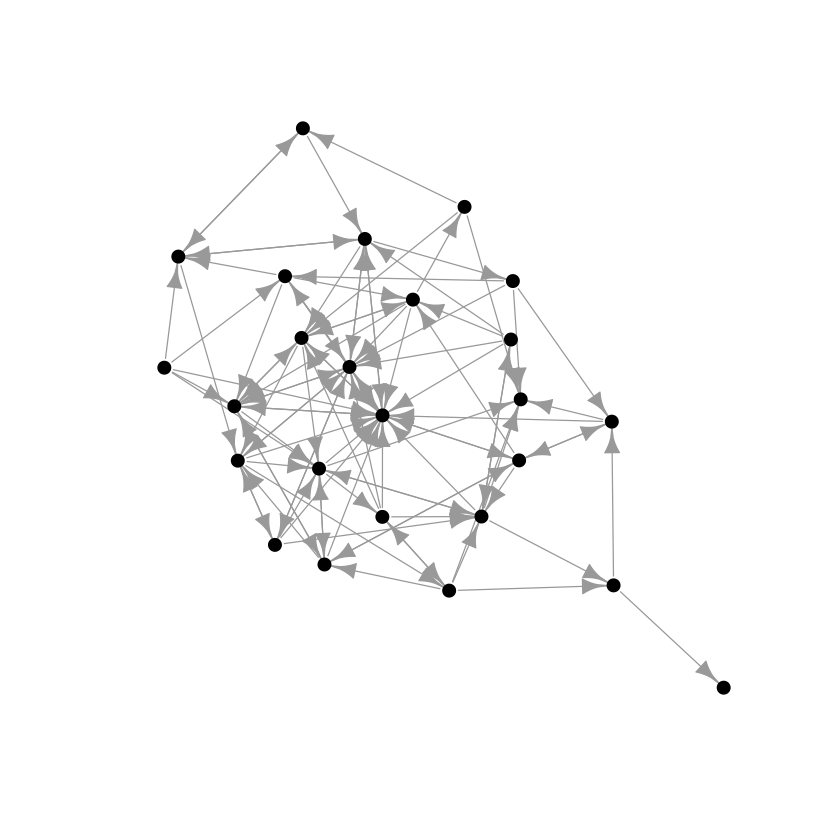

In [12]:
g1 = simplify(villages[[70]]$graph)
l1 = layout_with_kk(g1)
plot(
    g1,
    vertex.size = 5,
    vertex.label = NA, vertex.frame.color = NA,
    vertex.color="black",
    layout = l1
)

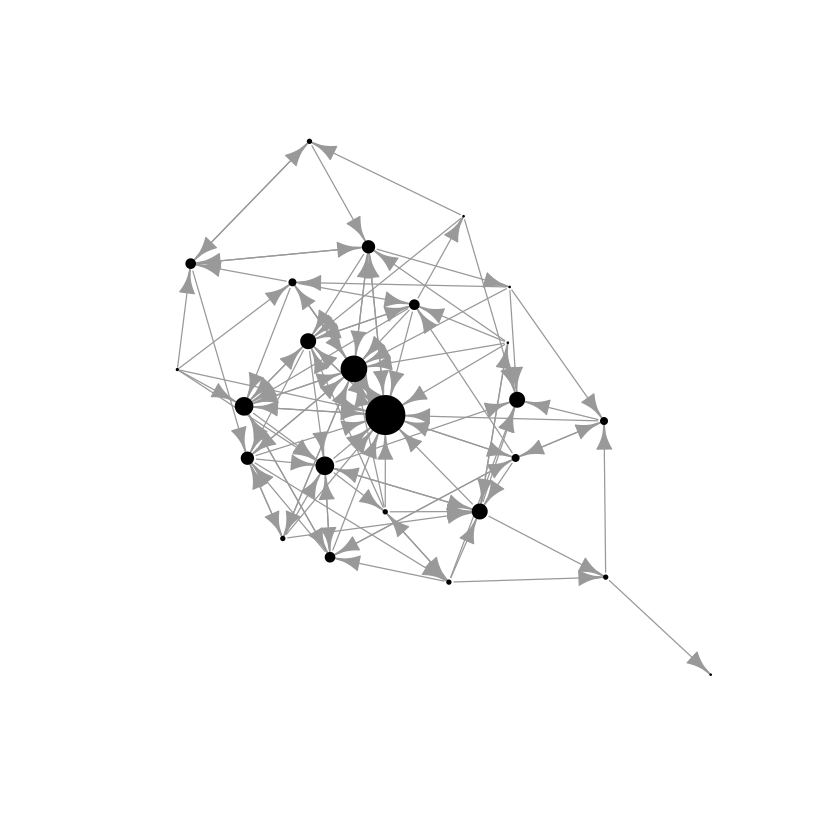

In [13]:
plot(
    g1,
    vertex.size = degree(g1, mode = "in"),
    vertex.label = NA, vertex.frame.color = NA,
    vertex.color="black",
    layout = l1
)

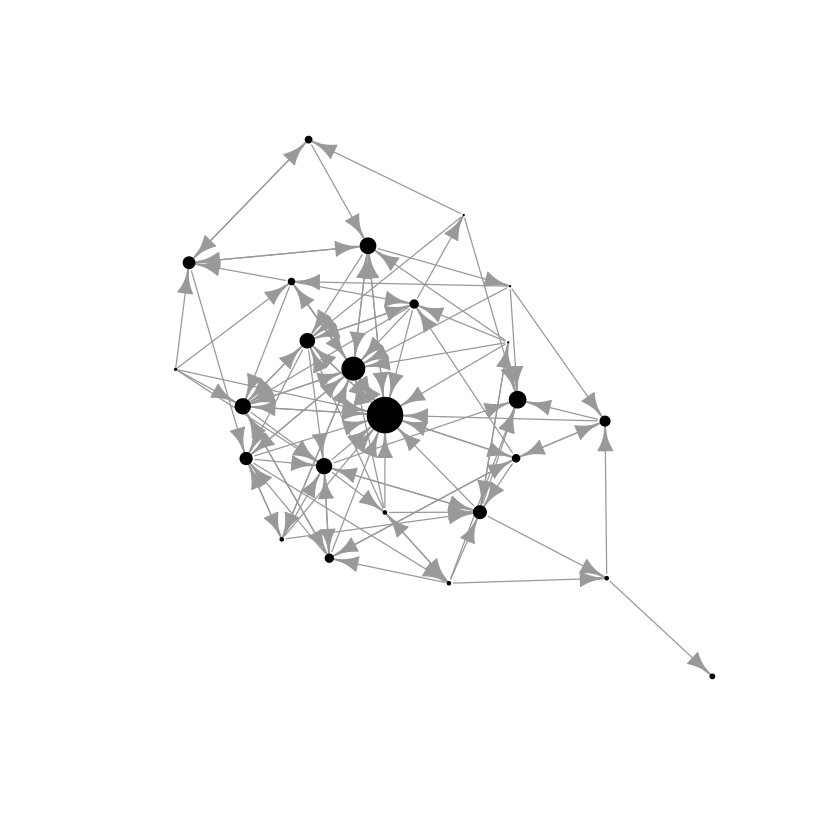

In [14]:
g1 = simplify(villages[[70]]$graph)
plot(
    g1,
    vertex.size = 1e2 * sapply(names(V(g1)), function(i) { compute_p_nom_one_seed(g1)[i]}),
    vertex.label = NA, vertex.frame.color = NA,
    vertex.color="black",
    layout = l1
)

In [15]:
names(villages[[1]])

[1] "name"               "nodes"              "edges"             
 [4] "graph"              "n_nodes"            "n_edges"           
 [7] "seed_set"           "ss_size"            "y"                 
[10] "p_rand"             "p_nom_unnormalized" "pi_hat"            
[13] "pi_hat_se"          "pi_hat_inv_se"      "p_nom"             
[16] "y_rate_seeds"       "y_rate_nonseeds"    "y_rate_delay"

In [16]:
df = foreach(v=villages, .combine=rbind) %dopar% {
    data.frame(
        village_name=v$name,
        n_nodes=v$n_nodes,
        n_edges=v$n_edges,
        mean_indegree=mean(degree(v$graph, mode = "in")),
        std_indegree=sd(degree(v$graph, mode = "in")),
        n_treated=v$ss_size,
        frac_treated=v$ss_size / v$n_nodes,
        p_rand=v$p_rand,
        p_nom=v$p_nom,
        p_nom_unnormalized=v$p_nom_unnormalized,
        y_rate=v$y,
        y_sum=v$y * v$n_nodes,
        y_rate_seeds=v$y_rate_seeds,
        y_rate_nonseeds=v$y_rate_nonseeds,
        y_rate_delay=v$y_rate_delay
    )
}

set.seed(1010); sample_n(df, 10)

village_name,n_nodes,n_edges,mean_indegree,std_indegree,n_treated,frac_treated,p_rand,p_nom,p_nom_unnormalized,y_rate,y_sum,y_rate_seeds,y_rate_nonseeds,y_rate_delay
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
xiashatouxi,40,115,2.875000,2.102349,12,0.3000000,1.789916e-10,0.000000e+00,0.000000e+00,0.5000000,20,0.4166667,0.53571429,0.5238095
shigang43,27,85,3.148148,1.974914,6,0.2222222,3.378264e-06,0.000000e+00,0.000000e+00,0.3333333,9,0.6666667,0.23809524,0.3846154
dazhoulaoji2,30,59,1.966667,1.564329,4,0.1333333,3.648969e-05,1.084142e-05,7.173515e-06,0.3000000,9,0.2500000,0.30769231,0.2727273
chaxishangchaxi,8,23,2.875000,1.356203,4,0.5000000,1.428571e-02,4.609705e-02,1.307231e-02,0.2500000,2,0.5000000,0.00000000,NaN
dayuwangjia,30,126,4.200000,2.821103,5,0.1666667,7.017248e-06,0.000000e+00,0.000000e+00,0.8333333,25,0.8000000,0.84000000,0.8823529
hefeng10,21,67,3.190476,1.913610,6,0.2857143,1.842842e-05,0.000000e+00,0.000000e+00,0.1428571,3,0.3333333,0.06666667,0.1000000
xingzengxingzeng1,38,87,2.289474,1.592345,10,0.2631579,2.115356e-09,0.000000e+00,0.000000e+00,0.5789474,22,0.6000000,0.57142857,0.5714286
xihuxinze1,28,64,2.285714,1.487158,7,0.2500000,8.445661e-07,0.000000e+00,0.000000e+00,0.5357143,15,0.8571429,0.42857143,0.3571429
fuzhouzhoujia,18,80,4.444444,3.239866,5,0.2777778,1.167134e-04,1.669186e-05,6.637708e-06,0.8888889,16,1.0000000,0.84615385,0.8888889


In [17]:
df = df %>% ungroup() %>%
    mutate(
        p_design = p_rand,
        w_nom = (p_nom / p_design) / sum(p_nom / p_design),
        w_rand = (p_rand / p_design) / sum(p_rand / p_design),
        w_diff = w_nom - w_rand
    )


In [18]:
table(df$n_treated)


 1  2  3  4  5  6  7  8  9 10 11 12 13 
 1  3 11 26 25 25 19 14 11  8  5  1  1 

Seed sets that include nodes with no incoming edges are impossible under (this version of) nomination. For example:

In [19]:
v1 = villages[[83]]
degree(v1$g, mode = "in")[as.character(v1$seed_set)]

22214152 22214175 22214180 22214182 22214189 22214190 22214191 22214192 
       6        1        4        1        3        7        2        0 
22214217 22214220 22214224 22214227 
       1        1        3        0

In [20]:
df_desc_summary = df %>% 
    mutate(
        `$\\log_{10} {m_i \\choose k_i}$` = log(choose(n_nodes, n_treated)),
        y_percent = y_rate * 100,
        percent_treated = frac_treated * 100
    ) %>%
    select(
        Edges = n_edges,
        `Nodes $m_i$` = n_nodes,
        `Treated count $k_i$` = n_treated,
        `Treated \\%` = percent_treated,
        `Takeup \\%` = y_percent,
        `$\\log_{10} {m_i \\choose k_i}$`,
        `Mean in-degree` = mean_indegree,
        `St. dev. in-degree` = std_indegree,
        #`Median in-degree` = median_indegree,
        #`Median out-degree` = median_outdegree
    ) %>%
    gather %>%
    group_by(key) %>% 
    summarise_all(funs(mean, sd, min, max))
df_desc_summary = df_desc_summary[c(2, 4, 3, 5, 7, 8, 1, 6),]
df_desc_summary

key,mean,sd,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Edges,93.000000,37.4058101,17.0000000,188.000000
Nodes $m_i$,27.586667,9.4451342,8.0000000,49.000000
Mean in-degree,3.351399,0.6730613,1.2142857,4.720000
St. dev. in-degree,2.369710,0.5655655,0.8925824,3.710165
Treated \%,22.866805,7.0477046,10.0000000,50.000000
Treated count $k_i$,6.153333,2.3308168,1.0000000,13.000000
$\log_{10} {m_i \choose k_i}$,12.718440,4.8896896,2.3025851,26.293886
Takeup \%,44.935628,19.5383185,5.1282051,95.833333


In [21]:
df_desc_summary %>%
    xtable(digits=1) %>%
    print.xtable(include.rownames = FALSE, sanitize.text.function = function(x) x)

% latex table generated in R 4.0.0 by xtable 1.8-4 package
% Sun Jun 14 15:47:09 2020
\begin{table}[ht]
\centering
\begin{tabular}{lrrrr}
  \hline
key & mean & sd & min & max \\ 
  \hline
Edges & 93.0 & 37.4 & 17.0 & 188.0 \\ 
  Nodes $m_i$ & 27.6 & 9.4 & 8.0 & 49.0 \\ 
  Mean in-degree & 3.4 & 0.7 & 1.2 & 4.7 \\ 
  St. dev. in-degree & 2.4 & 0.6 & 0.9 & 3.7 \\ 
  Treated \% & 22.9 & 7.0 & 10.0 & 50.0 \\ 
  Treated count $k_i$ & 6.2 & 2.3 & 1.0 & 13.0 \\ 
  $\log_{10} {m_i \choose k_i}$ & 12.7 & 4.9 & 2.3 & 26.3 \\ 
  Takeup \% & 44.9 & 19.5 & 5.1 & 95.8 \\ 
   \hline
\end{tabular}
\end{table}


In [22]:
table(df$p_nom == 0)


FALSE  TRUE 
   83    67 

### Plot probabilities

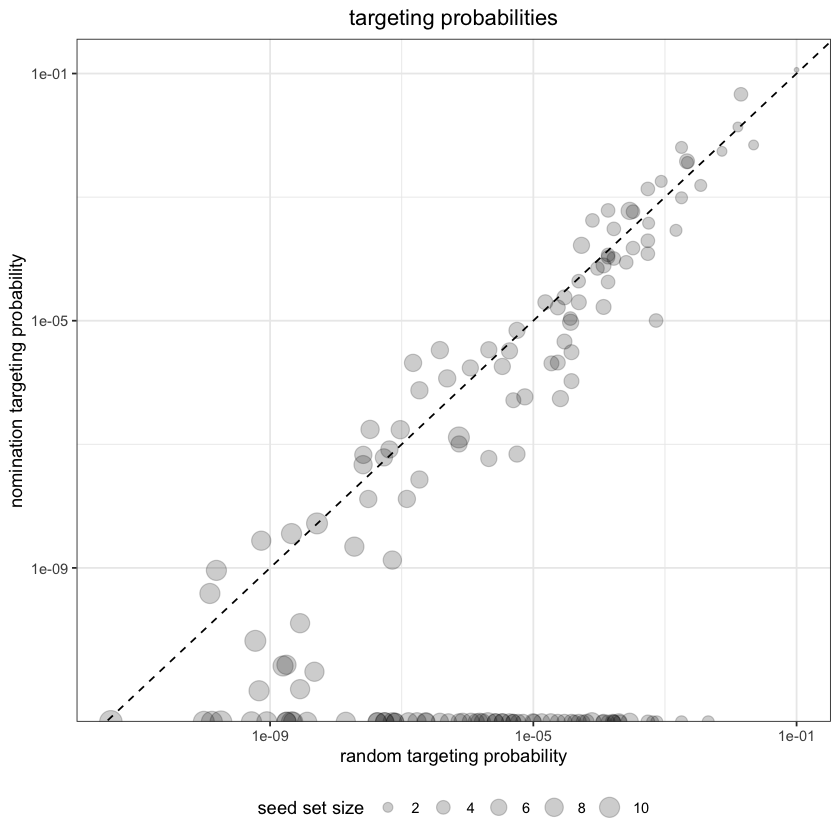

In [23]:
breaks = 10^(-4*(1:5) + 3)
p_probs = df %>% 
    ggplot(aes(p_rand, p_nom, size=n_treated)) + geom_point(alpha=0.2) +
    scale_y_log10(breaks=breaks) + scale_x_log10(breaks=breaks) +
    xlab('random targeting probability') + ylab('nomination targeting probability') +
    labs(size = 'seed set size') +
    theme_bw() + 
    ggtitle('targeting probabilities') +
#    ggtitle('Cai et al. (2015) targeting probabilities') +
    theme(plot.title = element_text(hjust = 0.5), legend.position='bottom') + 
    scale_size_continuous(breaks = c(2, 4, 6, 8, 10)) +
    geom_abline(slope=1, intercept = 0, linetype='dashed')
p_probs

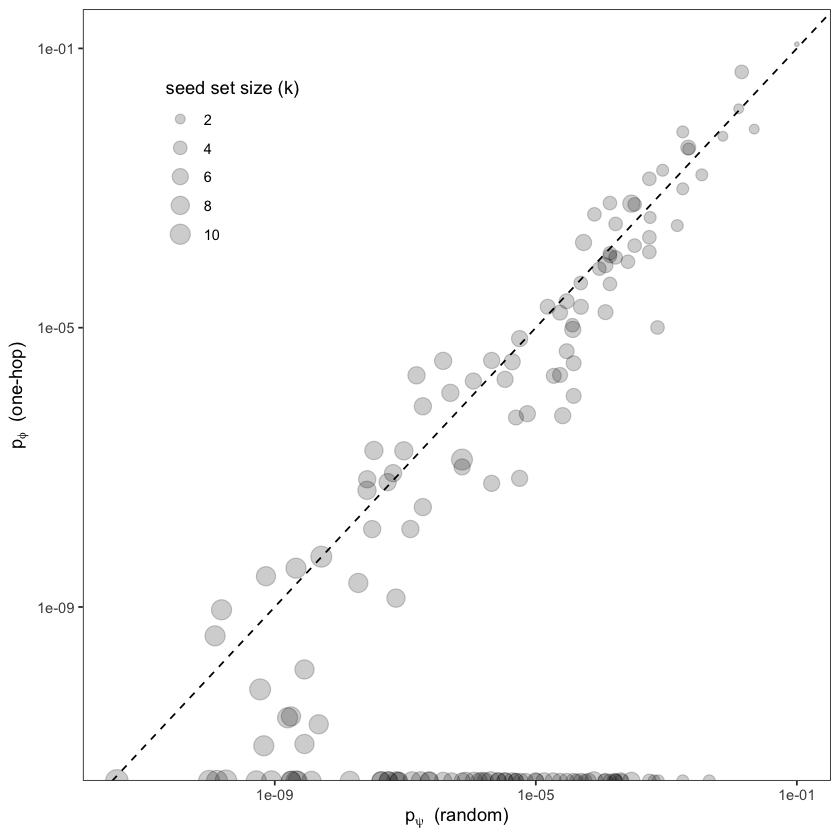

In [24]:
breaks = 10^(-4*(1:5) + 3)
p_probs_alt = df %>% 
    ggplot(aes(p_rand, p_nom, size=n_treated)) + geom_point(alpha=0.2) +
    scale_y_log10(breaks=breaks) + scale_x_log10(breaks=breaks) +
    xlab(expression(p[psi]*"  (random)")) +
    ylab(expression(p[phi]*"  (one-hop)")) +
    labs(size = 'seed set size (k)') +
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5),
          legend.position=c(0.2, 0.8),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank()) + 
    scale_size_continuous(breaks = c(2, 4, 6, 8, 10)) +
    geom_abline(slope=1, intercept = 0, linetype='dashed')
p_probs_alt
ggsave(
    'figures/cai_probs_scatterplot.pdf',
    p_probs_alt,
    width=4.5, height=4.5)

In [25]:
summary(df$n_treated)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   6.000   6.153   8.000  13.000 

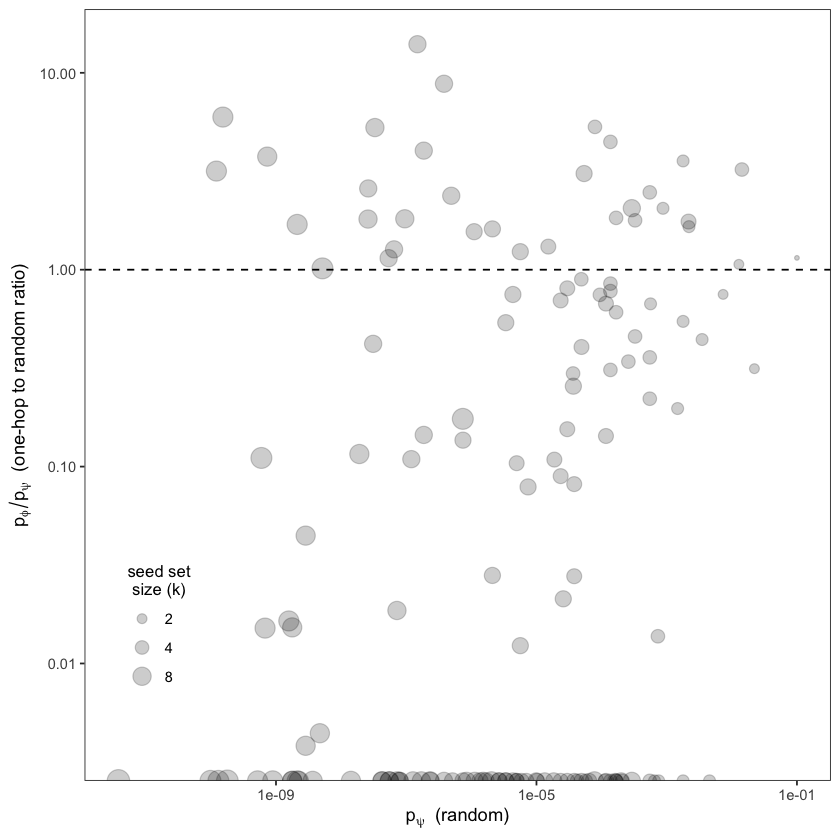

In [26]:
breaks = 10^(-4*(1:5) + 3)
p_probs_ratio = df %>% 
    ggplot(aes(p_rand, p_nom/p_rand, size=n_treated)) +
    geom_point(alpha=0.2) +
    scale_y_log10(breaks = 10^((-2:1))) + scale_x_log10(breaks=breaks) +
    xlab(expression(p[psi]* "  (random)")) +
    ylab(expression(p[phi] / p[psi] * "  (one-hop to random ratio)")) +
    labs(size = 'seed set\n size (k)') +
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5),
          legend.position=c(0.10, 0.2),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          legend.title=element_text(size=10),
          legend.background = element_rect(fill = "transparent")
         ) + 
    scale_size_continuous(breaks = c(2, 4, 8)) +
    geom_abline(slope=0, intercept = log10(1), linetype='dashed')
p_probs_ratio
ggsave(
    'figures/cai_probs_ratio_scatterplot.pdf',
    p_probs_ratio,
    width=4, height=4.5)

### Estimation and inference

In [27]:
df$y = df$y_rate

In [28]:
ht_est = df %>% horvitz_thompson
ht_se = df %>% ht_variance_estimate %>% sqrt
ht_est; ht_se; 2 * (1 - pnorm(abs(ht_est / ht_se)))

[1] -0.1384817

[1] 0.06470203

[1] 0.03233058

In [29]:
hajek_est = df %>% hajek
hajek_se = df %>% hajek_variance_estimate %>% sqrt
hajek_est; hajek_se; 2 * (1 - pnorm(abs(hajek_est / hajek_se)))

[1] -0.04361819

[1] 0.02088365

[1] 0.03674121

In [30]:
results = data.frame(
    estimator=c('ht', 'hajek'),
    est=c(horvitz_thompson(df), hajek(df)),
    var=c(ht_variance_estimate(df), hajek_variance_estimate(df))
) %>% mutate(
    se=sqrt(var), 
    pval=2 * (1 - pnorm(abs(est/se))),
    ci_lower=est - 1.96 * se,
    ci_upper=est + 1.96 * se)
results %>% select(-estimator) %>% t %>% 
    (function(r) {colnames(r) = results$estimator; r}) %>%
    xtable(digits=3) %>% 
    print.xtable()

% latex table generated in R 4.0.0 by xtable 1.8-4 package
% Sun Jun 14 15:47:11 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & ht & hajek \\ 
  \hline
est & -0.138 & -0.044 \\ 
  var & 0.004 & 0.000 \\ 
  se & 0.065 & 0.021 \\ 
  pval & 0.032 & 0.037 \\ 
  ci\_lower & -0.265 & -0.085 \\ 
  ci\_upper & -0.012 & -0.003 \\ 
   \hline
\end{tabular}
\end{table}


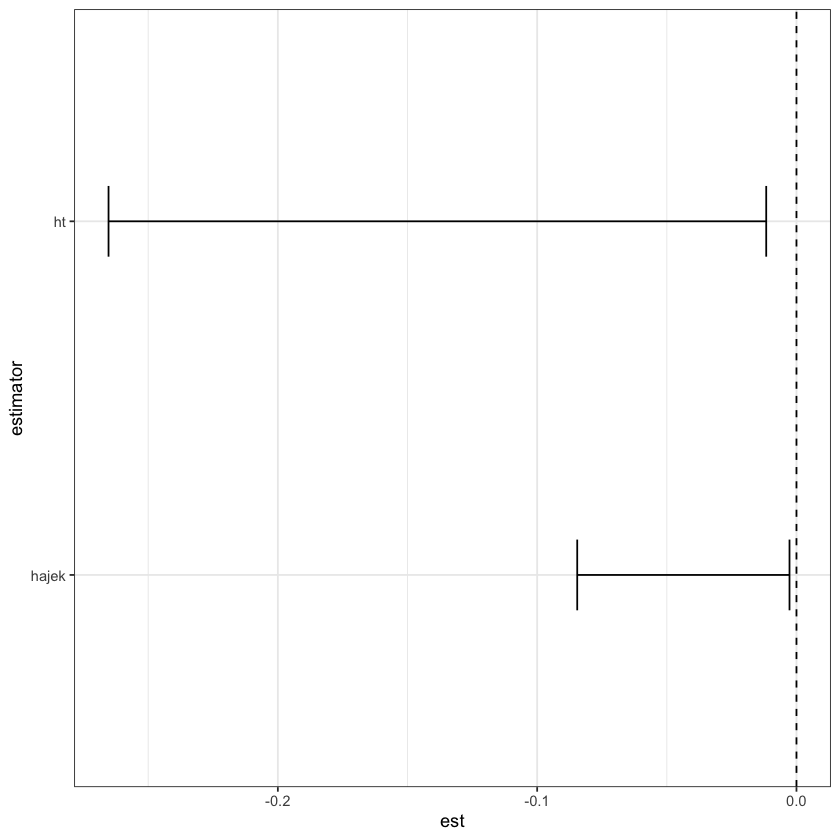

In [31]:
results %>% 
    ggplot(aes(x=est, y=estimator, xmin=ci_lower, xmax=ci_upper)) + 
    geom_errorbarh(height=0.2) + geom_vline(xintercept=0, linetype='dashed') + 
    theme_bw()

#### HT weights

In [32]:
df %>%
    arrange(p_rand)

village_name,n_nodes,n_edges,mean_indegree,std_indegree,n_treated,frac_treated,p_rand,p_nom,p_nom_unnormalized,y_rate,y_sum,y_rate_seeds,y_rate_nonseeds,y_rate_delay,p_design,w_nom,w_rand,w_diff,y
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
zhangxi4,49,172,3.510204,3.049060,13,0.2653061,3.808120e-12,0.000000e+00,0.000000e+00,0.26530612,13,0.2307692,0.27777778,0.4166667,3.808120e-12,0.000000e+00,0.006666667,-0.006666667,0.26530612
guojiahexi,45,153,3.400000,3.207945,11,0.2444444,9.851638e-11,0.000000e+00,0.000000e+00,0.28888889,13,0.1818182,0.32352941,0.4761905,9.851638e-11,0.000000e+00,0.006666667,-0.006666667,0.28888889
xiecheng8,49,169,3.448980,3.055468,10,0.2040816,1.216867e-10,3.856480e-10,6.543909e-11,0.42857143,21,0.9000000,0.30769231,0.3571429,1.216867e-10,2.757510e-02,0.006666667,0.020908435,0.42857143
zhangxi3,44,178,4.045455,3.710165,11,0.2500000,1.303893e-10,0.000000e+00,0.000000e+00,0.54545455,24,0.8181818,0.45454545,0.5600000,1.303893e-10,0.000000e+00,0.006666667,-0.006666667,0.54545455
dayuminjia,48,188,3.916667,2.735374,10,0.2083333,1.528885e-10,9.110990e-10,2.028153e-10,0.31250000,15,0.2000000,0.34210526,0.4444444,1.528885e-10,5.185136e-02,0.006666667,0.045184694,0.31250000
xiashatouxi,40,115,2.875000,2.102349,12,0.3000000,1.789916e-10,0.000000e+00,0.000000e+00,0.50000000,20,0.4166667,0.53571429,0.5238095,1.789916e-10,0.000000e+00,0.006666667,-0.006666667,0.50000000
daxiwujiajiaohengtou,43,162,3.767442,2.543313,10,0.2325581,5.215573e-10,0.000000e+00,0.000000e+00,0.39534884,17,0.5000000,0.36363636,0.5217391,5.215573e-10,0.000000e+00,0.006666667,-0.006666667,0.39534884
minzhu6,39,116,2.974359,2.400517,11,0.2820513,5.966388e-10,6.600707e-11,5.272370e-12,0.35897436,14,0.7272727,0.21428571,0.3000000,5.966388e-10,9.626055e-04,0.006666667,-0.005704061,0.35897436
donganlaojiluojia,42,156,3.714286,1.978984,10,0.2380952,6.796050e-10,1.027854e-11,2.291663e-12,0.40476190,17,0.3000000,0.43750000,0.5652174,6.796050e-10,1.315964e-04,0.006666667,-0.006535070,0.40476190


In [33]:
df_wts = rbind(
    df %>% 
        mutate(rand=1/n_villages, nom=p_nom / (n_villages*p_rand)) %>% 
        gather(estimand, wt, rand, nom, -village_name) %>% 
        mutate(estimator='ht') %>%
        select(estimand, estimator, wt, y, village_name),
    df %>% 
        mutate(rand=1/n_villages, nom=p_nom / p_rand) %>%
        mutate(nom=nom / sum(nom)) %>%
        gather(estimand, wt, rand, nom, -village_name) %>% 
        mutate(estimator='hajek') %>%
        select(estimand, estimator, wt, y, village_name) 
) %>% mutate(estimator = estimator %>% as.factor %>% relevel('ht'))

df_wts = df_wts %>%
    mutate(
        estimand = ifelse(estimand == "rand", "random", "one-hop")
    )

head(df_wts)

,estimand,estimator,wt,y,village_name
,<chr>,<fct>,<dbl>,<dbl>,<chr>
1,random,ht,0.006666667,0.6428571,xihuxinze2
2,random,ht,0.006666667,0.3913043,xinlian1314
3,random,ht,0.006666667,0.7500000,fuzhouxinkanshang
4,random,ht,0.006666667,0.2820513,hefeng14
5,random,ht,0.006666667,0.1304348,xinlian56
6,random,ht,0.006666667,0.6363636,beidangxinzhi


In [34]:
df_wts %>% filter(estimator == 'hajek', estimand == 'random') %>%
    summarise(
        sum_wt = sum(wt),
        mean_wt = mean(wt),
        mean_norm_wt = mean(wt / sum_wt)
    )

sum_wt,mean_wt,mean_norm_wt
<dbl>,<dbl>,<dbl>
1,0.006666667,0.006666667


### Effective sample size

In [35]:
nom_wts = df_wts %>% filter(estimand == 'one-hop', estimator=='ht') %>% .$wt
n_villages * mean(nom_wts)^2 / mean(nom_wts^2)

[1] 24.98162

### Point estimates

In [36]:
estimates = df_wts %>%
    group_by(estimand, estimator) %>% 
    summarise(estimate=sum(wt * y))

`summarise()` regrouping output by 'estimand' (override with `.groups` argument)



In [37]:
df_wts %>% group_by(estimator, estimand) %>% summarise(sum(wt))

`summarise()` regrouping output by 'estimator' (override with `.groups` argument)



estimator,estimand,sum(wt)
<fct>,<chr>,<dbl>
ht,one-hop,0.7661952
ht,random,1.0000000
hajek,one-hop,1.0000000
hajek,random,1.0000000


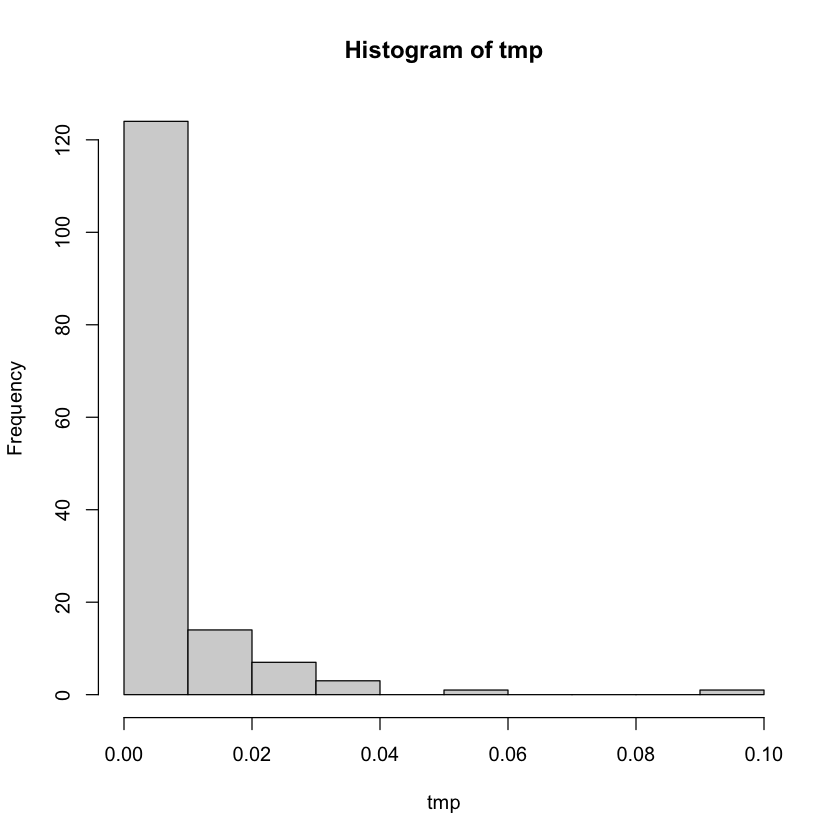

In [38]:
tmp = df_wts %>% filter(estimator=='ht', estimand == 'one-hop') %>% .$wt
hist(tmp)

In [39]:
labels <- c(
    'ht' = 'unnormalized/Horvitz-Thompson',
    'hajek' = 'normalized/Hajek'
)

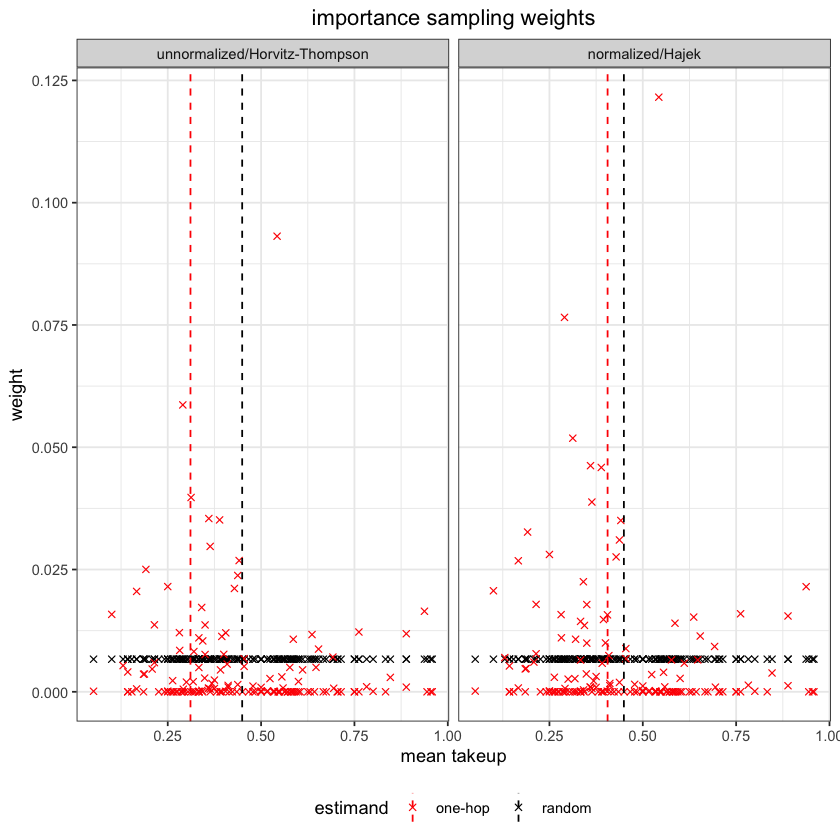

In [40]:
p_weights = df_wts %>%
    ggplot(aes(y, wt, group=estimand, colour=estimand)) +
    geom_point(shape=4) +
    facet_grid(. ~ estimator, labeller=as_labeller(labels)) +
    geom_vline(data=estimates, aes(xintercept=estimate, colour=estimand), linetype='dashed') +
    theme_bw() +
    scale_colour_manual(values=palette1) +
    xlab('mean takeup') + ylab('weight') +
    ggtitle('importance sampling weights') +
    #ggtitle('Cai et al. (2015) importance sampling weights') +
    theme(plot.title = element_text(hjust = 0.5), legend.position='bottom')
p_weights
ggsave('figures/cai_weights.png', width=7, height=4)

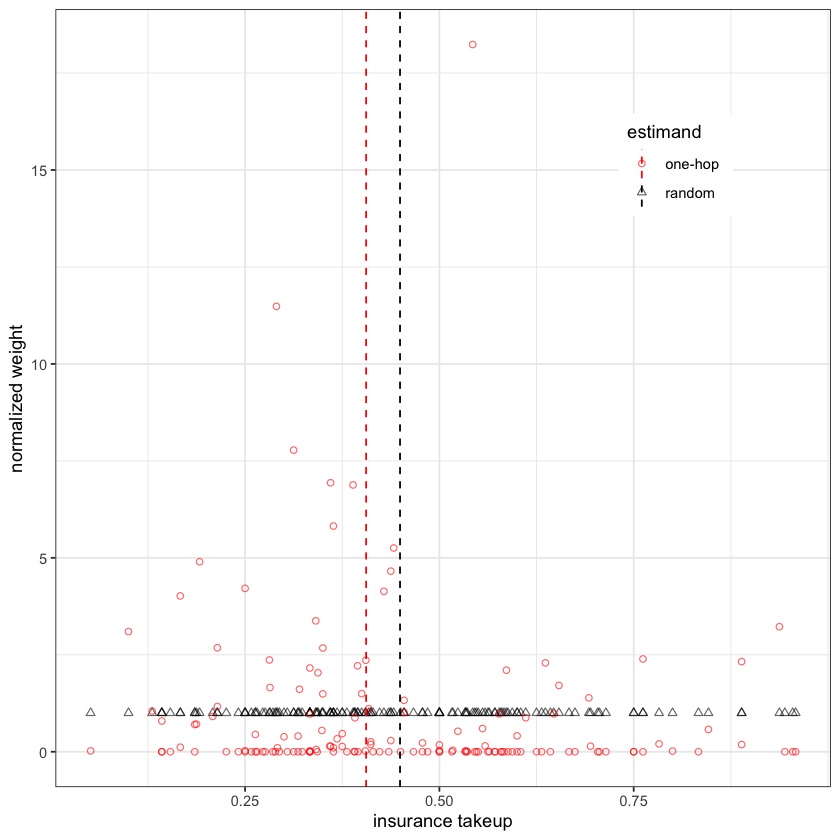

In [129]:
p_weights_hajek = df_wts %>%
filter(estimator == "hajek") %>%
mutate(wt = wt * n()/2) %>%
    ggplot(aes(y, wt, group=estimand, colour=estimand, shape=estimand)) +
    geom_point(alpha = .6) +
    geom_vline(
        data=estimates %>% filter(estimator == "hajek"),
        aes(xintercept=estimate, colour=estimand), linetype='dashed') +
    theme_bw() +
    scale_colour_manual(values=palette1) +
    scale_shape_manual(values=shapes2) +
    scale_x_continuous(breaks = c(0, .25, .5, .75)) +
    xlab('insurance takeup') + ylab('normalized weight') +
    #ggtitle('Cai et al. (2015) importance sampling weights') +
    theme(plot.title = element_text(hjust = 0.5), legend.position=c(.8, .8))
p_weights_hajek
ggsave('figures/cai_weights_hajek.pdf', width=4, height=4)

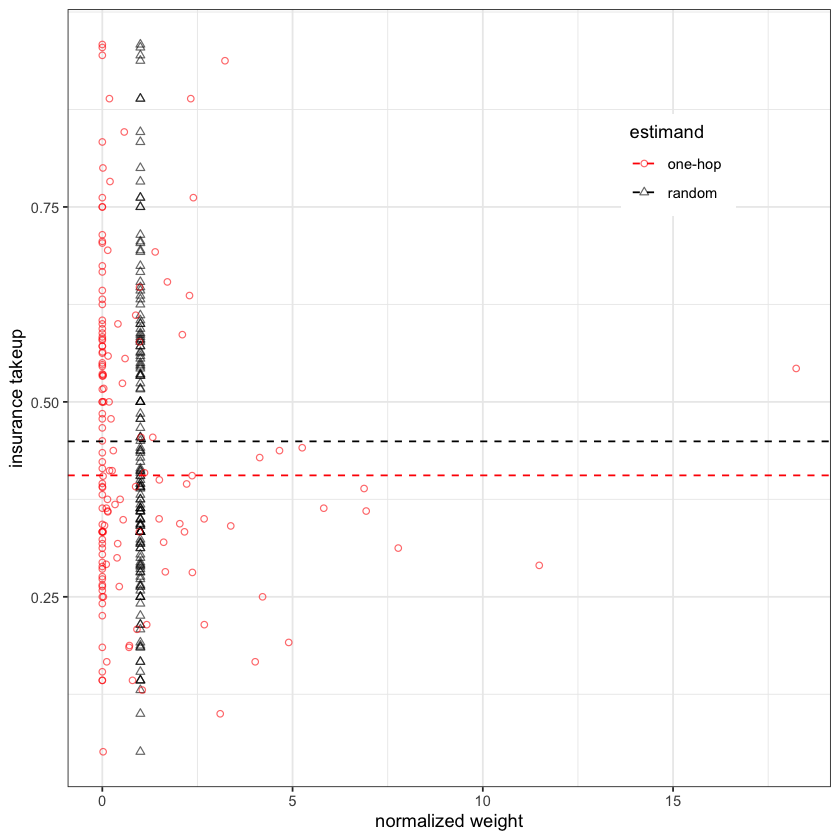

In [130]:
p_weights_hajek = df_wts %>%
filter(estimator == "hajek") %>%
mutate(wt = wt * n()/2) %>%
    ggplot(aes(wt, y, group=estimand, colour=estimand, shape=estimand)) +
    geom_point(alpha = .6) +
    geom_hline(
        data=estimates %>% filter(estimator == "hajek"),
        aes(yintercept=estimate, colour=estimand), linetype='dashed') +
    theme_bw() +
    scale_colour_manual(values=palette1) +
    scale_shape_manual(values=shapes2) +
    scale_y_continuous(breaks = c(0, .25, .5, .75)) +
    ylab('insurance takeup') + xlab('normalized weight') +
    #ggtitle('Cai et al. (2015) importance sampling weights') +
    theme(plot.title = element_text(hjust = 0.5), legend.position=c(.8, .8))
p_weights_hajek
ggsave('figures/cai_weights_hajek_flipped.pdf', width=4, height=4)

### Plot weights for ATE

In [43]:
df_wts_ate = df_wts %>%
    group_by(estimator, village_name) %>%
    summarise(
        ate_wt = wt[estimand == 'one-hop'] - wt[estimand == 'random'],
        y = mean(y)
    )

`summarise()` regrouping output by 'estimator' (override with `.groups` argument)



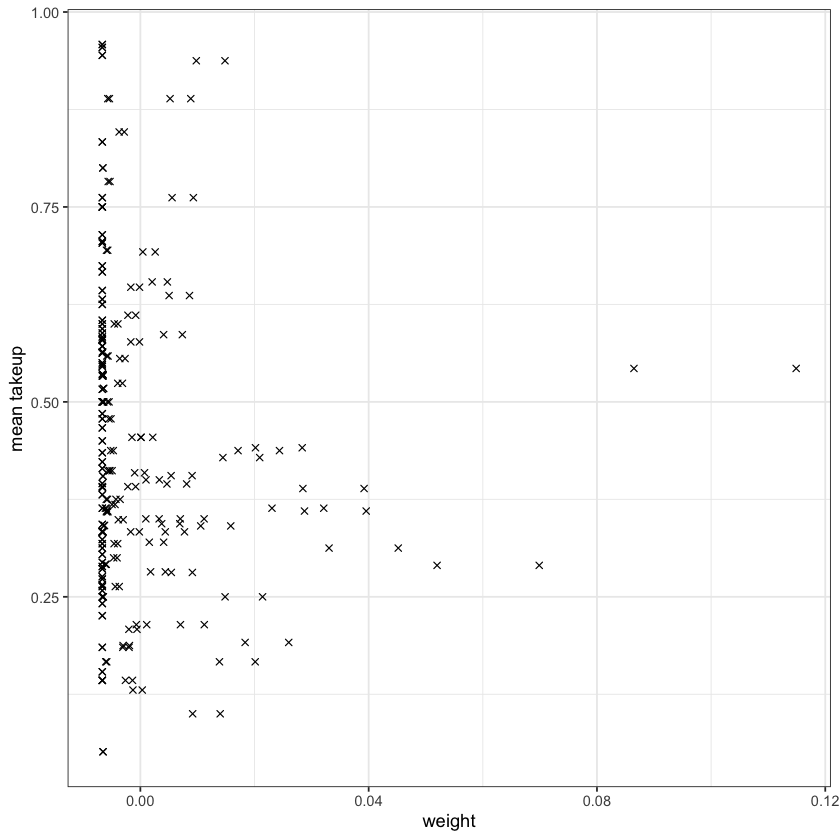

In [44]:
p_weights_hajek = df_wts_ate %>%
    ggplot(aes(x = ate_wt, y = y)) +
    geom_point(shape=4) +
    theme_bw() +
    scale_colour_manual(values=palette1) +
    ylab('mean takeup') + xlab('weight') +
    theme(plot.title = element_text(hjust = 0.5), legend.position=c(.8, .8))
p_weights_hajek

Combine plots 

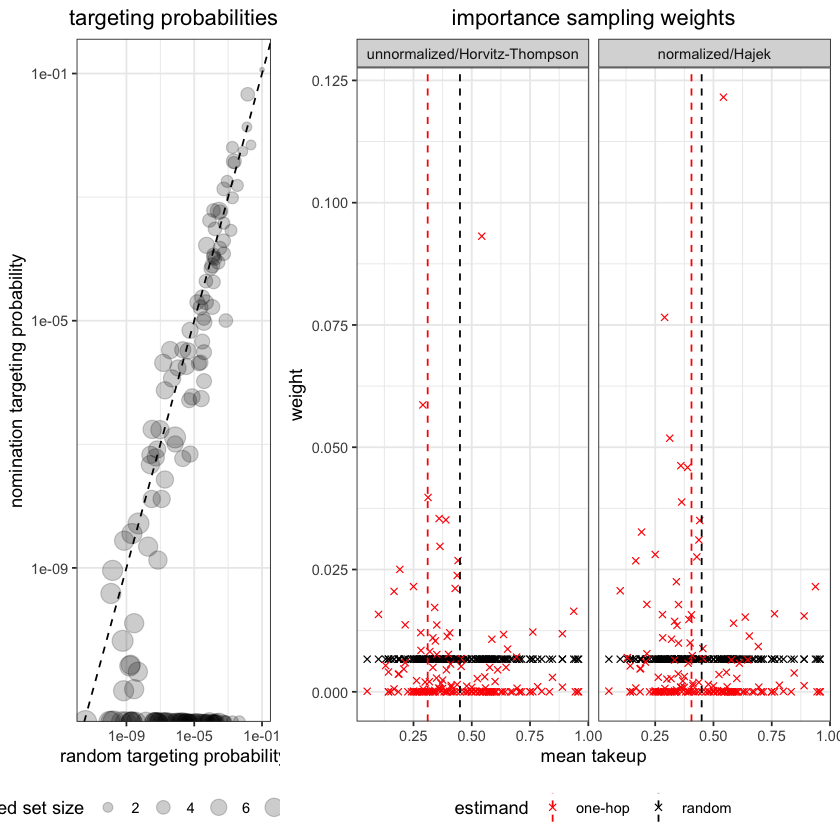

In [45]:
p = grid.arrange(
    p_probs, p_weights, layout_matrix=matrix(c(1, 2, 2), nrow=1))
ggsave(p, file='figures/cai_plot.png', width=12, height=5)

## Permutation test

In [120]:
permutation_cai = function(df, villages, R = 1000, alpha = 0.05,
                           p_nom_perm = NULL, keep_perms = TRUE,
                           estimator = hajek,
                           variance_estimator = hajek_variance_estimate,
                           outcome = 'y') {
    est = estimator(df)
    est_var = variance_estimator(df)
    t_obs = est / sqrt(est_var)
    
    df$y = df[, outcome]

    # compute permutations, unless provided
    if (is.null(p_nom_perm)) {
      p_nom_perm =  foreach(i = 1:length(villages), .combine = rbind) %do% {
        v = villages[[i]] 
        z = v$nodes$trt
    
        p_nom_perm_vi = foreach(r = 1:R, .combine = c) %dopar% {
            zp = sample(z)
            ss_p = v$nodes$id[zp]
            .compute_p_nom(v$graph, ss_p, v$pi_hat)
        }
      }
    }
    # compute stats for each permutation
    perm = foreach(r = 1:ncol(p_nom_perm), .combine = rbind) %dopar% { 
        df$p_nom = p_nom_perm[, r]
        data.frame(
          est = estimator(df),
          est_var = variance_estimator(df)
        )
    } %>%
    mutate(
        t = est / sqrt(est_var)
    )

    p = c(alpha / 2, 1 - alpha / 2)
    result = list(
        est = est,
        t_naive = t_obs,
        est_perm = perm$est,
        t_perm = perm$t,
        variance = var(perm$t * sqrt(est_var)),
        null_low = quantile(perm$t, p[1]),
        null_high = quantile(perm$t, p[2]),
        p_value = 2 * min(mean(t_obs > perm$t), mean(t_obs < perm$t))
    )
    if (keep_perms) {
        result$p_nom_perm = p_nom_perm
    }
    return(result)
}

In [ ]:
set.seed(1808)
perm1 = permutation_cai(df, villages, R = 1e4, keep_perms = TRUE)

In [ ]:
saveRDS(perm1$p_nom_perm, "cai_p_nom_permutations.RDS")

In [47]:
p_nom_perm_1 = readRDS("cai_p_nom_permutations.RDS")

In [121]:
perm1 = permutation_cai(
    df, villages, R = 1e4,
    p_nom_perm = p_nom_perm_1,
    keep_perms = FALSE
)

In [116]:
perm1$p_value

[1] 0.0974

In [122]:
df$y_rank = rank(df$y)

In [123]:
perm_rank = permutation_cai(
    df, villages, R = 1e4,
    p_nom_perm = p_nom_perm_1,
    keep_perms = FALSE,
    outcome = 'y_rank'
)

In [124]:
perm_rank$p_value

[1] 0.0954

In [92]:
set.seed(18082)
boot_1 = hajek_bootstrap_variance_estimate(
  df,
  alpha = .05, R = 1000
)
boot_1

,variance,low,high
,<dbl>,<dbl>,<dbl>
3.182405%,0.0006601926,-0.09093758,0.008788347


In [93]:
results_hajek_perm = results %>%
    filter(estimator == "hajek") %>%
    mutate(
        var_boot = boot_1$variance,
        ci_lower_boot = boot_1$low,
        ci_upper_boot = boot_1$high,
        se_boot = sqrt(var_boot)
    )
results_hajek_perm$p_value_perm = perm1$p_value
results_hajek_perm

estimator,est,var,se,pval,ci_lower,ci_upper,var_boot,ci_lower_boot,ci_upper_boot,se_boot,p_value_perm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
hajek,-0.04361819,0.000436127,0.02088365,0.03674121,-0.08455015,-0.002686226,0.0006601926,-0.09093758,0.008788347,0.02569421,0.0974


In [94]:
results_hajek_perm %>%
    mutate(
        `95\\% CI (analytic)` = sprintf("[%0.4f, %0.4f]", ci_lower, ci_upper),
        `95\\% CI (bootstrap)` = sprintf("[%0.4f, %0.4f]", ci_lower_boot, ci_upper_boot),
    ) %>%
    select(
        `estimate  (one-hop $-$ rand)` = est,
        `SE (analytic)` = se,
        `SE (bootstrap)` = se_boot,
        `95\\% CI (analytic)`,
        `95\\% CI (bootstrap)`,
        `p-value (analytic)` = pval,
        `p-value (Fisherian)` = p_value_perm
    ) %>%
    format(
        digits=2, width = 4, justify = "right",
        nsmall = 4,
        zero.print = TRUE
    ) %>%
    t() %>%
    xtable(digits=8) %>% 
    print.xtable(sanitize.text.function = function(x) x)

% latex table generated in R 4.0.0 by xtable 1.8-4 package
% Sun Jun 14 16:08:58 2020
\begin{table}[ht]
\centering
\begin{tabular}{rl}
  \hline
 & 1 \\ 
  \hline
estimate  (one-hop $-$ rand) & -0.0436 \\ 
  SE (analytic) & 0.0209 \\ 
  SE (bootstrap) & 0.0257 \\ 
  95\% CI (analytic) & [-0.0846, -0.0027] \\ 
  95\% CI (bootstrap) & [-0.0909, 0.0088] \\ 
  p-value (analytic) & 0.0367 \\ 
  p-value (Fisherian) & 0.0974 \\ 
   \hline
\end{tabular}
\end{table}


In [97]:
perm1$est

[1] -0.04361819

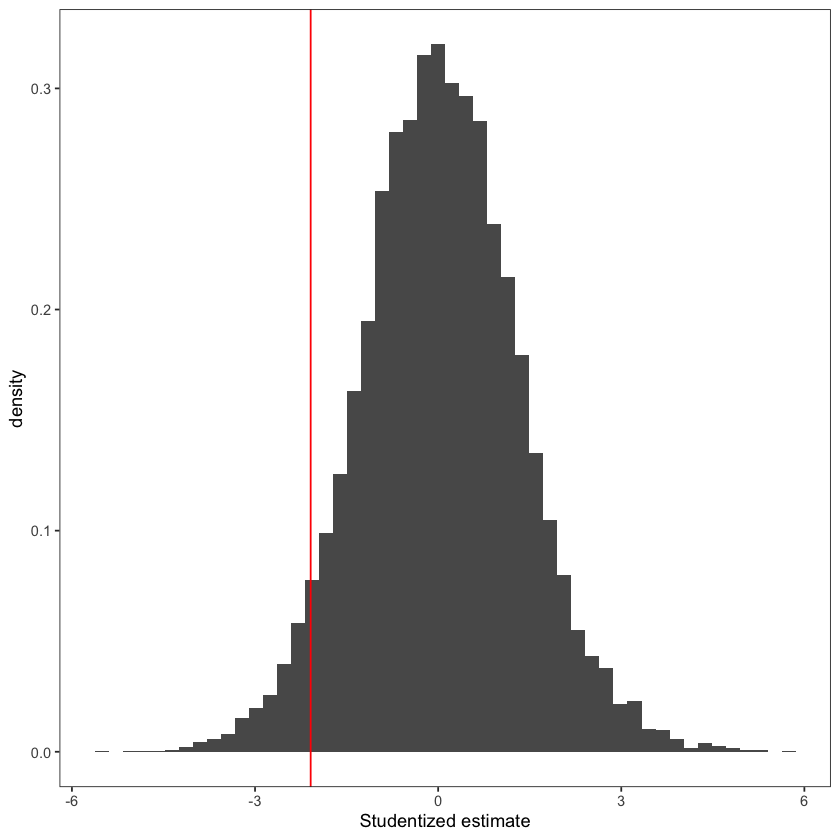

In [119]:
perm_t_hist = ggplot(
  aes(x = t, y = ..density..),
  data = data.frame(t = perm1$t_perm)
) +
  geom_histogram(bins = 50) +
  geom_vline(
    xintercept = perm1$t_naive,
    color = "red"
  ) +
  xlab("Studentized estimate") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
perm_t_hist

ggsave(
  "figures/cai_perm_t_hist.pdf",
  perm_t_hist,
  width = 4, height = 2.5
    )